This notebook includes functions for plotting the figures reported in the paper.

In [15]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [16]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [17]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [18]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

# Setting global variables 

In [19]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/tests/20240610_new_algo/v1


In [20]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/10242023_v3.3/results"

# Directory to save figures
PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("../stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [21]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [22]:
folders = ["new_algo_v1_baseline", "new_algo_v1_baseline__5runs"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.8104260891910134]
values [0.807880547310041]
values [0.8202828031882079]
values [0.8075864519229385]
values [0.8206381074533696]
values [0.8042893619209703]
values [0.8091432856401033]
values [0.80403759931182]
values [0.7961968717635708]
values [0.8106476730303297]
Overall quality when there is no bots: 0.81


# Bot params

## Read data 
Data is a subset of joint effect experiments

### Gamma

In [38]:
data = read_data(
    RES_DIR, folders=["new_algo_v1", "new_algo_v1_5runs", "new_algo_v1__5runs"]
)
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0_x,quality_0_y,quality_1,quality_2,quality_3,quality_4,quality_0
0,1,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.785712,0.784553,0.770928,0.782140,0.778814,0.778218,0.782136
1,1,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.773890,0.756550,0.777114,0.767548,0.773446,0.759827,0.783888
2,1,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.791813,0.784443,0.773247,0.777333,0.776292,0.799279,0.787019
3,1,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.670080,0.688371,0.681321,0.695631,0.677146,0.691908,0.667463


In [39]:
# Reset quality cols
vary_gamma = reindex_cols(data, col_name_prefix="quality")

In [40]:
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9710782769685462, 0.9696455021171806, 0.9528059863376743, 0.9666632405440879, 0.9625532564278375, 0.9618158020935479, 0.9666580863572964]
values [0.9564677834819507, 0.9350359628403363, 0.9604515185544956, 0.9486287033036057, 0.9559183576706443, 0.9390867049796388, 0.9688235996768373]
values [0.9786191611093824, 0.9695098518310666, 0.9556724549294915, 0.9607224623735837, 0.959436353665131, 0.9878460981945442, 0.9726931975345666]
values [0.8281658821183879, 0.850771992556489, 0.8420598615832684, 0.8597447306457887, 0.8368987636499244, 0.8551437039497422, 0.8249321567347803]


## Single param plots
Subset data (only plot default values for each panel)

### Plot

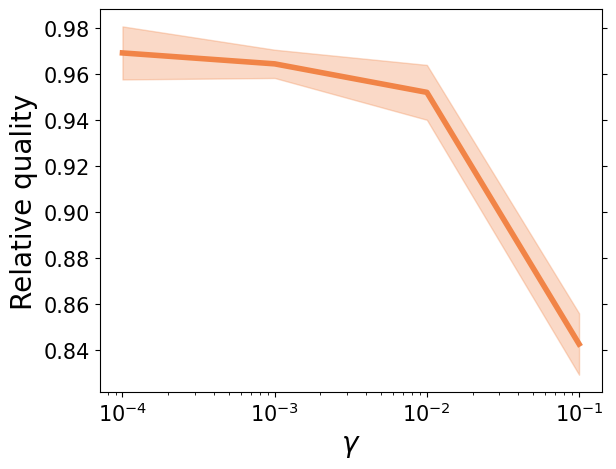

In [41]:
fpath = os.path.join(PLOT_DIR, "gamma")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, ax = plt.subplots()  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# fig, axs = plt.subplots(
#     1, 3, figsize=(20, 5), sharey=True
# )  # same size with contour plot
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
# plt.subplots_adjust(
#     left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
# )

plt.tight_layout()
if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [27]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=["theta", "phi"], keep="first")
thetaphi = thetaphi.pivot(
    index="theta", columns="phi", values="mean_relative_quality"
).reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ["theta"] + PHI
thetaphi.head()

NameError: name 'thetaphi' is not defined

In [ ]:
tp_matrix = thetaphi.loc[:, PHI].values
# Check shape:
tp_matrix.shape

### Data: Thetagamma matrix

In [ ]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=["theta", "gamma"], keep="first")
thetagamma = thetagamma.pivot(
    index="theta", columns="gamma", values="mean_relative_quality"
).reset_index()
thetagamma.head()

In [ ]:
tg_matrix = thetagamma.loc[:, GAMMA].values
tg_matrix.shape

### Data: Phigamma matrix

In [ ]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=["phi", "gamma"], keep="first")
phigamma = phigamma.pivot(
    index="phi", columns="gamma", values="mean_relative_quality"
).reset_index()
phigamma.head()

In [ ]:
pg_matrix = phigamma.loc[:, GAMMA].values
pg_matrix.shape

### Plot

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238


def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$"


fpath = os.path.join(PLOT_DIR, "joint")
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN = np.round(min_qual, 2)
VMAX = np.round(max_qual, 2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax = axs[0]
surf = ax.plot_surface(
    np.log2(X),
    np.log10(Y),
    Z,
    cmap=cmap,
    linewidth=0,
    antialiased=False,
    vmin=VMIN,
    vmax=VMAX,
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


## PHIGAMMA
ax = axs[1]

X = PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(
    X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, 0.27, 0.03, 0.5])  # x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, cax=cbar_ax)


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax = axs[2]
surf = ax.plot_surface(
    np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [ ]:
data = read_data(RES_DIR, folders=["strategies_5runs"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

In [ ]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()